Here, you develop the E+M Runge-Kuttas. (You want to be able to graph two functions at a time. The plotting functions can handle it, but the other functions aren't built for it specifically because your cases are simple enough that the answer for the B field is proportional to the E Field.)

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 64
refRatio = 2
CFL = np.sqrt(0.5)
ntC = 50
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 1
order = 1

L = 1
locs = [x_1]
epsilons = [1, 0.5] # [1, 1]
mus = [1, 0.5] # [1, 1]

func = WFT.Gauss # SquareWave
plotCont = True
enlarge = True

In [3]:
omegaAMR = BT.Grid(nh_min)
finehalf = list(np.arange(int(nh_min / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
omegaC = BT.Grid(nh_min)

wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
nullspaceBlock = OT.Block(nullspace, var = 2)
restrictOp = GTT.CoarsenOp(omegaAMR)
restrictOpBlock = OT.Block(restrictOp, var = 2)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

In [4]:
physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
c = physicsAMR.cVec
cMatAMR = physicsAMR.cMat

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat

cVecC = physicsC.cVec
c1 = cVecC[0]
c2 = cVecC[-1]

In [5]:
# mu, sigma = WFT.GaussParams(x_0, x_1)
sigma = 1. / 32.
mu = 0.25
args = [sigma, mu]

nt = int(2*ntC)
t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = nt)


In [6]:
# Initialize wave.
waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
waveInitF = WFT.InitCond(omegaF, physicsF, func, args)
waveInitAMR = restrictOpBlock @ waveInitF

# Find Fourier coefficients of initialized wave.
FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)

# Propagate analytic solution.
wavePropC = WFT.WaveEq(omegaC, physicsC, func, args, t)
wavePropF = WFT.WaveEq(omegaF, physicsC, func, args, t)
wavePropAMR = WFT.WaveEq(omegaAMR, physicsC, func, args, t)

# Find Fourier coefficients of propagated solution.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC)
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF)
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

# Load up Fourier coefficients.
allCoefsC = PT.Load(FCoefsC, FCoefsPropC)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF)
allCoefsAMR = nullspaceBlock @ PT.Load(FCoefsAMR, FCoefsPropAMR)

labels = ['Initial Wave', 'Analytically Propagated Wave']

Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?
Are you *sure* your labels are ordered correctly?


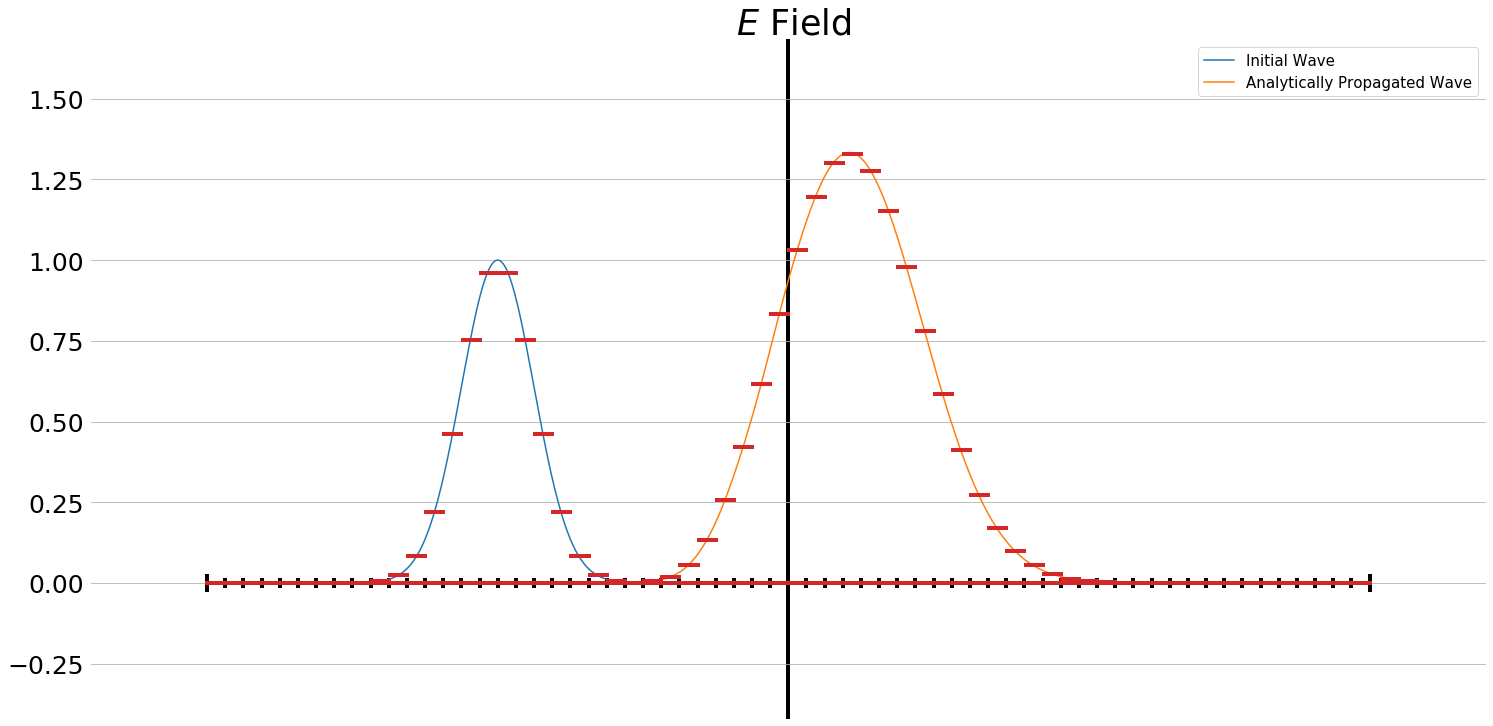

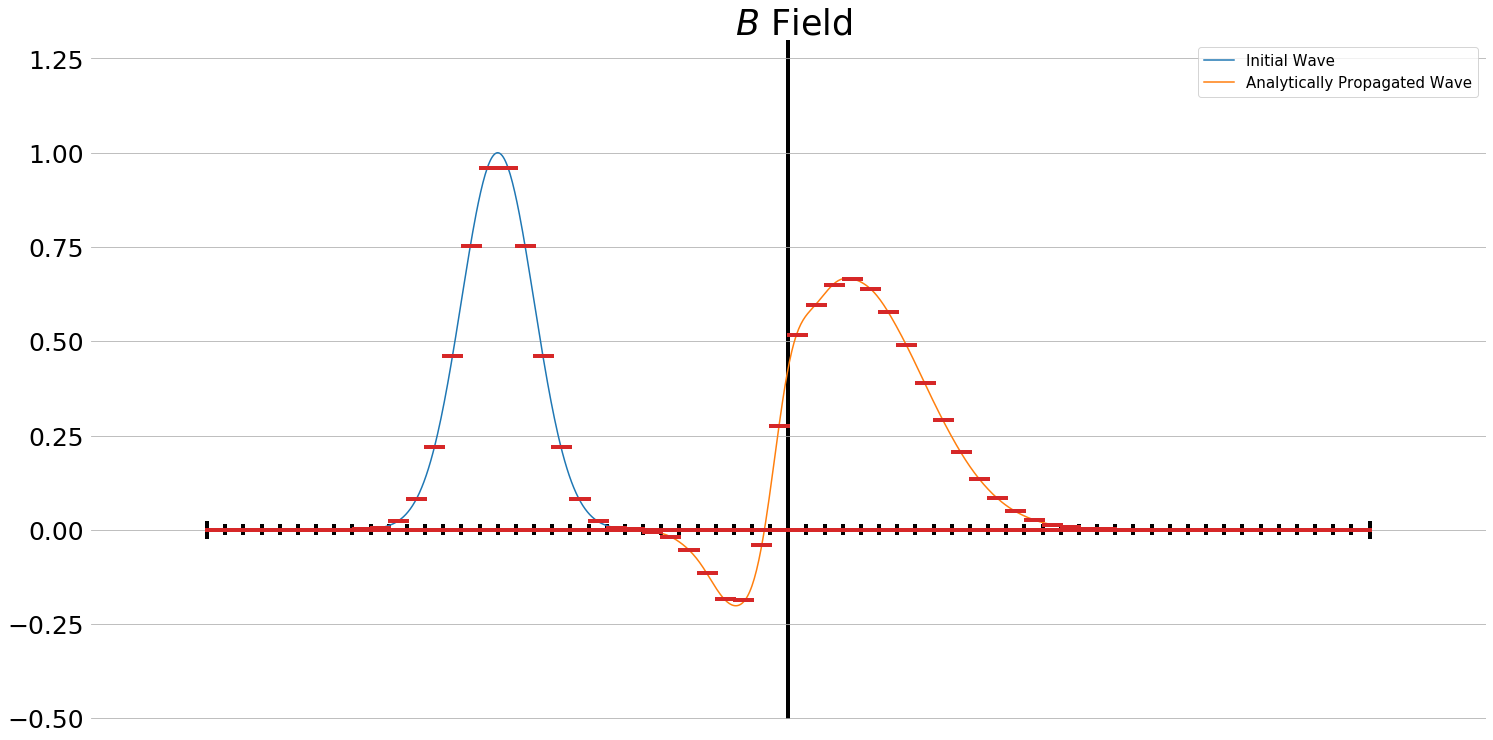

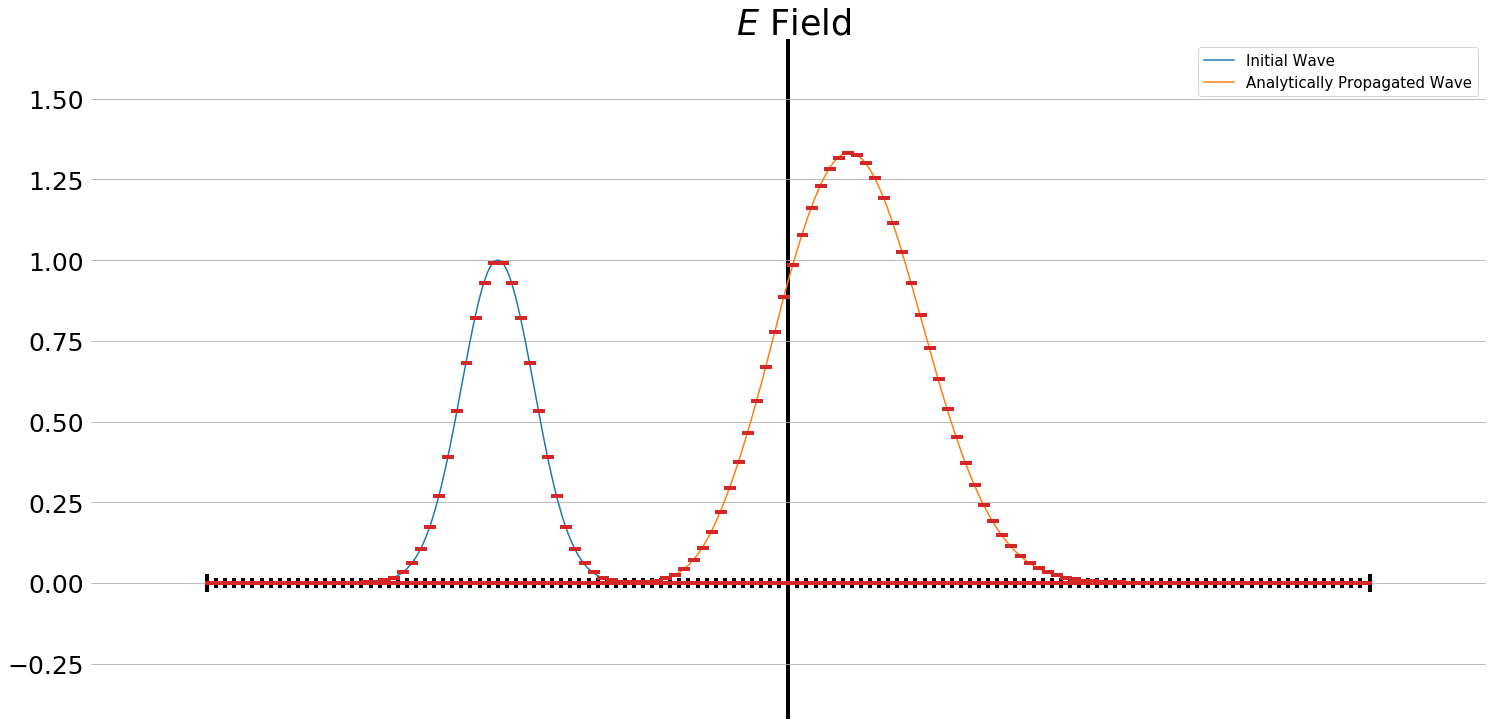

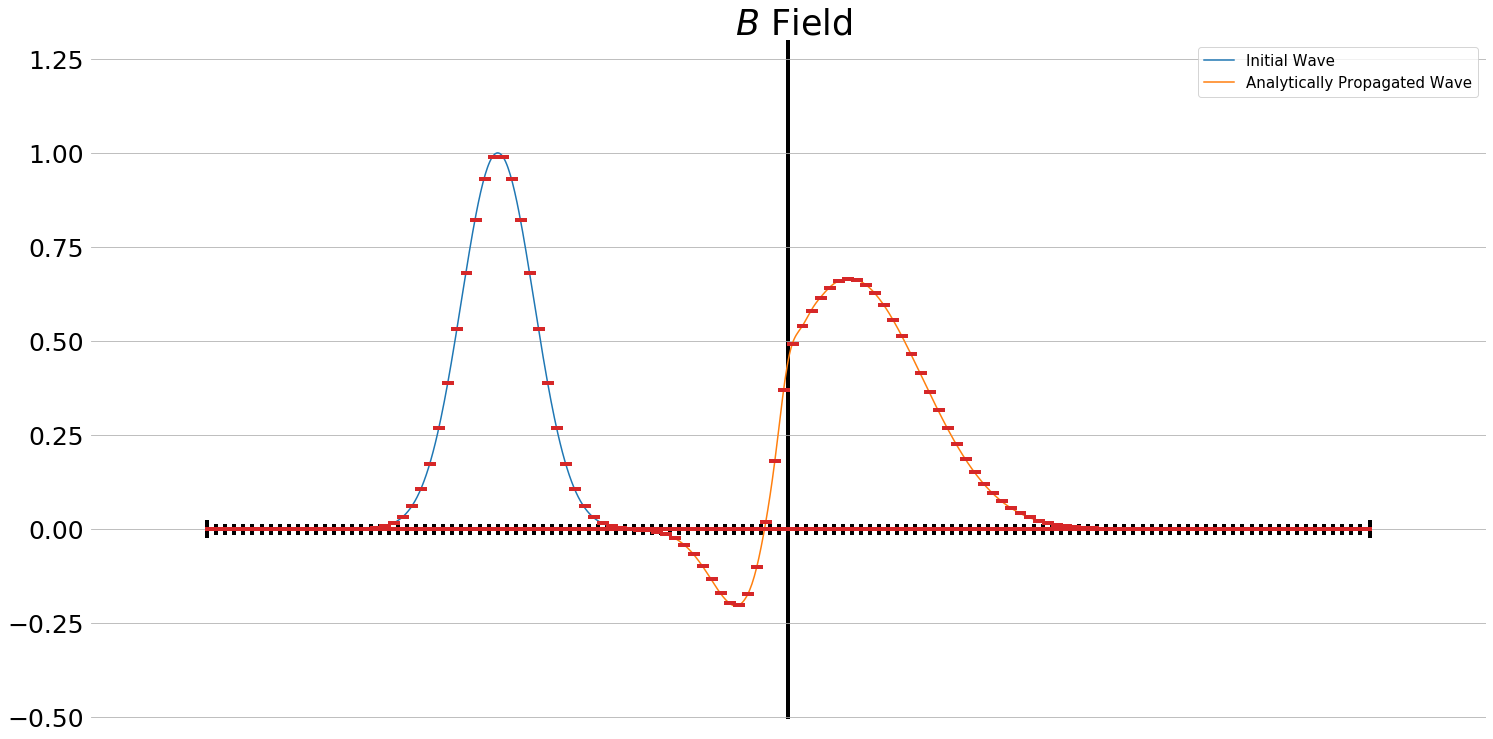

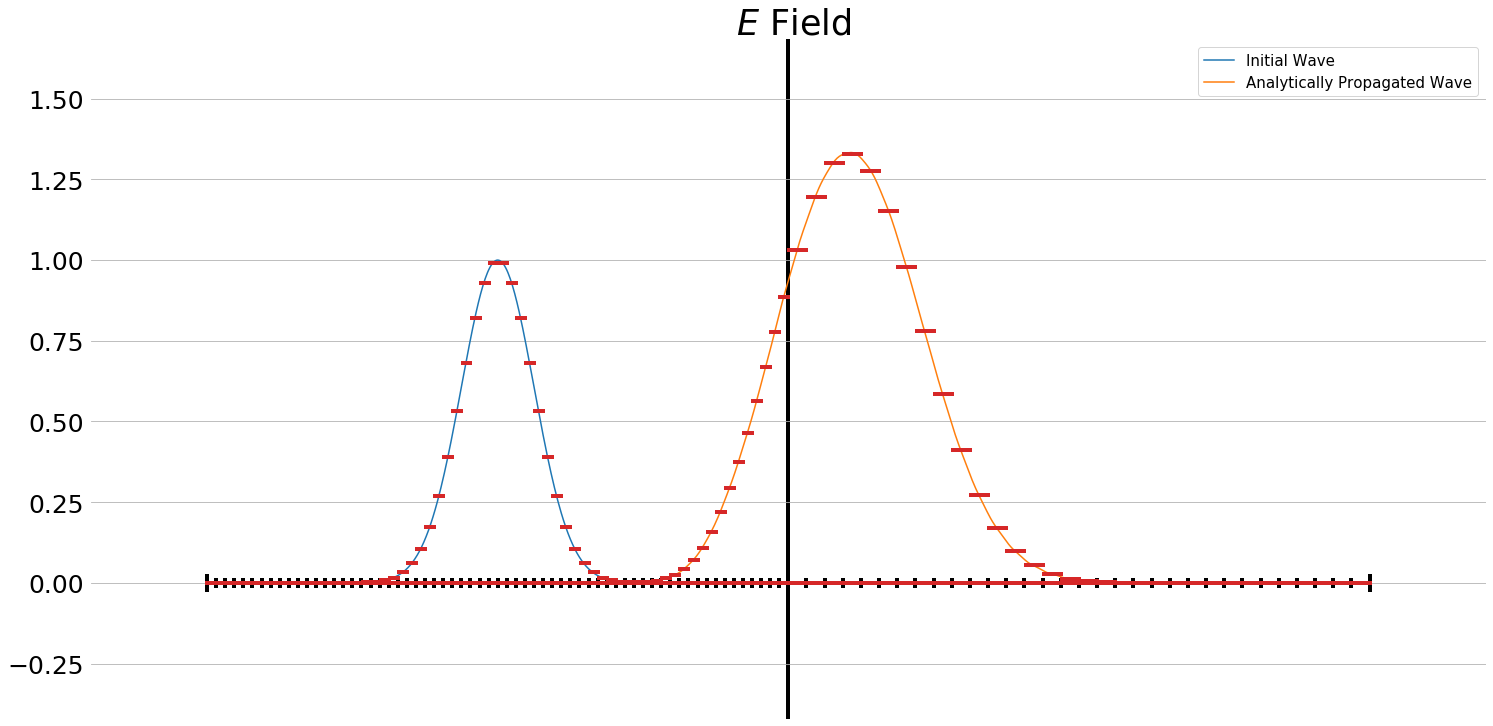

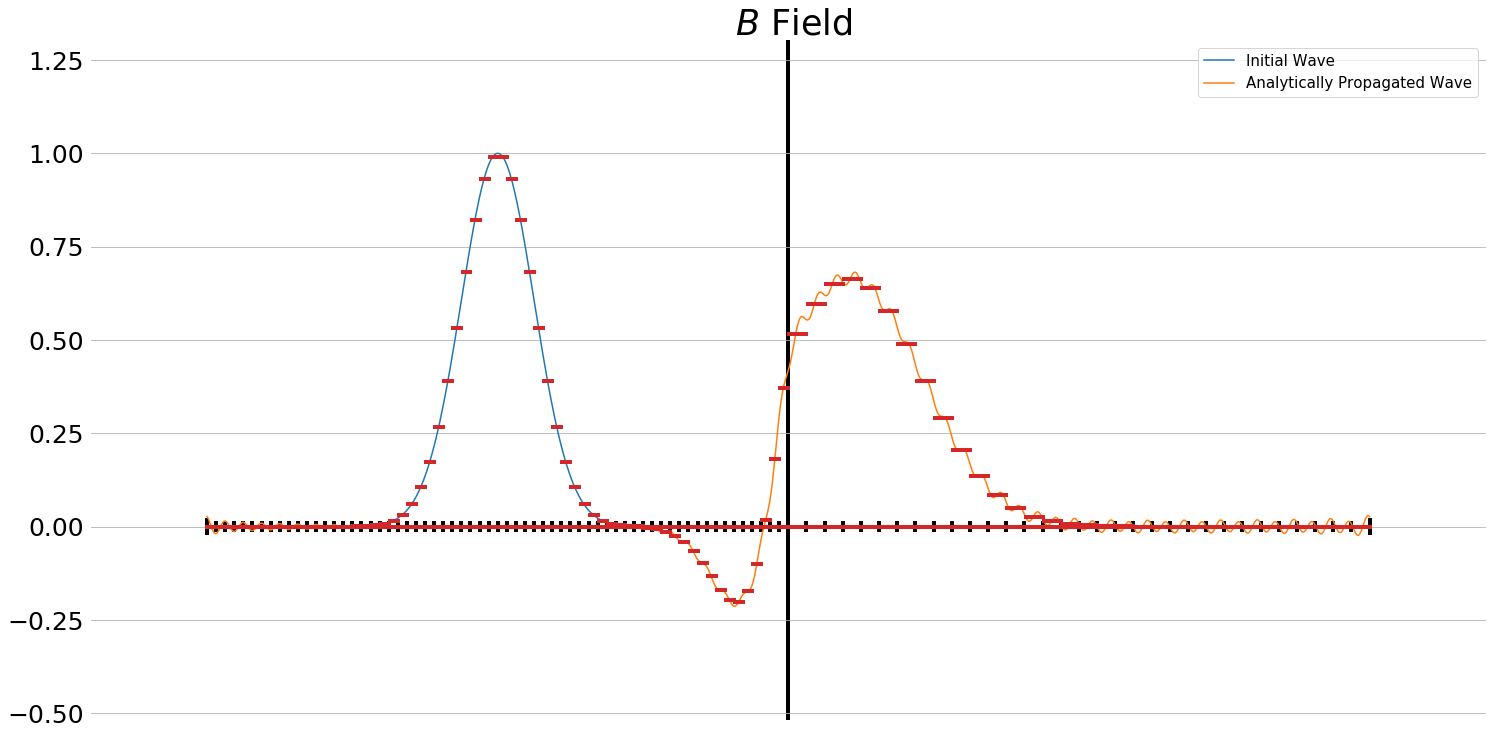

In [7]:
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, plotCont = plotCont, enlarge = enlarge)#, saveName = 'RKWaveEqAttempt2')#, saveName = 'Coarse', dpi = 300)
PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, enlarge = enlarge, plotCont = plotCont)#, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True, labels = labels, enlarge = enlarge, plotCont = plotCont)#, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)
